# 5. Test set evaluation 
We now use top models from the grid search to deploy on test

In [1]:
%load_ext autoreload
%autoreload 2

Note: the below is similar to the code seen in "protein-eval.py", use the selected models in notebook #4 to hardcode model strings

In [2]:
encoder_list = ["COLLAPSE", "ESM", "AA"]
test_metrics = ["ap", "auprc"]
metal = 'ZN'
# hard coded for now from looking at top of ranked dataframe
encoder_top_models = { \
    'COLLAPSE': ('k25_r4_cutoff8.00_alpha1.0000_tau4.00_lamnan.model', 0.75), \
    # 'COLLAPSE': ('k15_r1_cutoff8.00_alpha0.0100_tau0.00_lamnan.model', 0.8), \
    'ESM': ('k20_r1_cutoff8.00_alpha1.0000_tau0.00_lamnan.model', 0.8), \
    'AA': ('k21_r1_cutoff8.00_alpha0.010_tau1.00_lamnan.model', 0.5)}

baseline_top_models = \
    {'COLLAPSE': ('COLLAPSE-ZN-8.0-0.0001-100', 0.7), \
    'ESM': ('ESM-ZN-6.0-0.001-500', 0.4), \
    'AA': ('AA-ZN-6.0-0.001-200', 0.5)}

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
pal = sns.color_palette('tab20')

In [4]:
from evaluation import test_eval, extract_params, get_test_metrics
import utils
import pandas as pd

In [29]:
baselines = ['Attention', 'GNNExplainer', 'SHAP']
base_df = []
for encoder in encoder_list:
    for baseline in baselines:
        for model_thresh_pair in baseline_top_models[encoder]:
            best_model, best_thresh = baseline_top_models[encoder]
            results_dict = utils.deserialize(f'../data/baselines/{encoder}_{baseline}_test_results.pkl')
            df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
            # add a "method" column to the df (K2, Attn, Prob)
            df["method"] = "GAT+"+baseline
            base_df.append(df)
base_df = pd.concat(base_df)
base_df['datum_id'] = base_df['datum_id'] + '.pkl'

In [14]:
base_df.groupby(['encoder', 'method']).size()

encoder   method          
AA        GAT+Attention       1008
          GAT+GNNExplainer    1008
          GAT+SHAP            1008
COLLAPSE  GAT+Attention       1008
          GAT+GNNExplainer    1008
          GAT+SHAP            1008
ESM       GAT+Attention        964
          GAT+GNNExplainer     964
          GAT+SHAP             964
dtype: int64

In [9]:
# from evaluation import compute_seg_all_configs

# cache_dir = "/dfs/scratch1/gmachi/gcp_backup/k2/"
# Gs_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_"
# label_dict_path = "/dfs/scratch1/gmachi/gcp_backup/k2/refined_label_dicts/refined_test_labeldict-" 
# gts_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_"

# test_df = compute_seg_all_configs(encoder_top_models, cache_dir, Gs_dir, gts_path, label_dict_path)

Note: the below cell takes about 8min to run

In [7]:
test_df = []
for encoder, (model_str, threshold) in encoder_top_models.items():
    results_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-eval_results"
    model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_models"
    processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_processors"
    linearized_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-linearized_data"

    _,_,cutoff,_,_,_ = extract_params(model_str)

    if encoder == 'AA':
        g_encoder = 'COLLAPSE'
    else:
        g_encoder = encoder

    G_dir = f"../data/{g_encoder}_{metal}_{cutoff}_test_graphs_2"

    df = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=None, label_dict=None, modality="graph", arm="test")
    df['method'] = 'Prospector'
    test_df.append(df)
test_df = pd.concat(test_df)

In [33]:
combined_df = pd.concat([test_df, base_df])

mean_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].mean().reset_index()
sem_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].sem().reset_index()

mean_pvt = mean_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
mean_pvt = mean_pvt[test_metrics]

sem_pvt = sem_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
sem_pvt = sem_pvt[test_metrics]

#Save dfs
# mean_pvt.to_csv(f'../data/all_test_results_mean-{test_metrics[0]}.csv')
# sem_pvt.to_csv(f'../data/all_test_results_sem-{test_metrics[0]}.csv')
# combined_df.to_csv(f'../data/all_test_results_points-{test_metrics[0]}.csv') # graph-level results
# test_df.to_csv(f'../data/k2_test_results_points-{test_metrics[0]}.csv')  # k2 only


# Properties vs performance

In [24]:
from evaluation import compute_test_mrds, compute_test_rps, compute_test_mcs, compute_test_ccs

G_dir = f"../data/COLLAPSE_ZN_8.0_test_graphs_2"
rps_dict = compute_test_rps(G_dir, gt_key='gt')
mrds_dict = compute_test_mrds(G_dir, gt_key='gt')
ccs_dict = compute_test_ccs(G_dir, gt_key='gt')
mcs_dict = compute_test_mcs(G_dir, gt_key='gt')

/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/oak/stanford/groups/rbaltman/aderry/K2/src/evaluation.py:605: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(size_cc) / len(size_cc) # prevalence / num CC


In [34]:
# test_df['rp'] = test_df['datum_id'].map(rps_dict)
# test_df['mrd'] = test_df['datum_id'].map(mrds_dict)
# test_df['ccs'] = test_df['datum_id'].map(ccs_dict)
# test_df['mcs'] = test_df['datum_id'].map(mcs_dict)
# test_df['srp'] = test_df['rp'] / test_df['ccs']

combined_df['rp'] = combined_df['datum_id'].map(rps_dict)
combined_df['mrd'] = combined_df['datum_id'].map(mrds_dict)
combined_df['ccs'] = combined_df['datum_id'].map(ccs_dict)
combined_df['mcs'] = combined_df['datum_id'].map(mcs_dict)
combined_df['srp'] = combined_df['rp'] / combined_df['ccs']

In [37]:
# test_df = test_df.reset_index(drop=True).dropna()
combined_df = combined_df.reset_index(drop=True).dropna()

In [38]:
combined_df['method'].unique()

array(['Prospector', 'GAT+Attention', 'GAT+GNNExplainer', 'GAT+SHAP'],
      dtype=object)

In [39]:
top_baseline = "GAT+GNNExplainer"

In [41]:
import numpy as np
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'full')

In [72]:
met="auprc"
# filtered_df = test_df[test_df['metric'] == met]

filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[~filtered_df["pipeline"].isin(['ESM-'+top_baseline, 'AA-'+top_baseline])]

/tmp/ipykernel_20890/3765552088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


In [73]:
filtered_df.pipeline.unique()

array(['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], dtype=object)

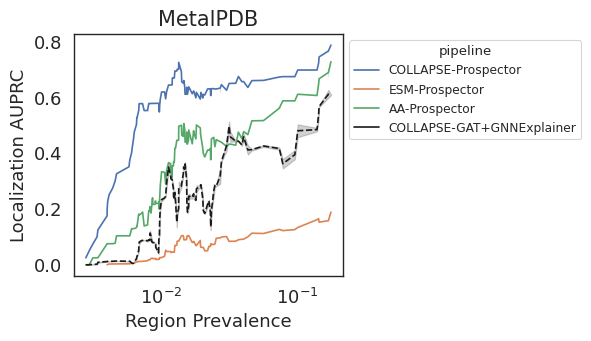

In [74]:
running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])

setup_figure(6,3.5)
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', hue_order=['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], palette=sns.color_palette()[:3] + ['k'])
g.lines[3].set_linestyle("--")

g.set_xscale("log")
 
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/k2-rp_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

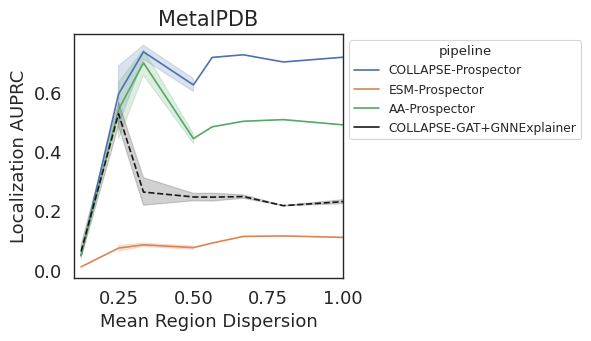

In [75]:
running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])


setup_figure(6,3.5)
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', hue_order=['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], palette=sns.color_palette()[:3] + ['k'])
g.lines[3].set_linestyle("--")

g.set_xlim(0.1, 1)
# g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/k2-mrd_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

In [76]:
met="ap"
# filtered_df = test_df[test_df['metric'] == met]

filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[~filtered_df["pipeline"].isin(['ESM-'+top_baseline, 'AA-'+top_baseline])]

/tmp/ipykernel_20890/3974977117.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


In [67]:
filtered_df.pipeline.unique()

array(['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], dtype=object)

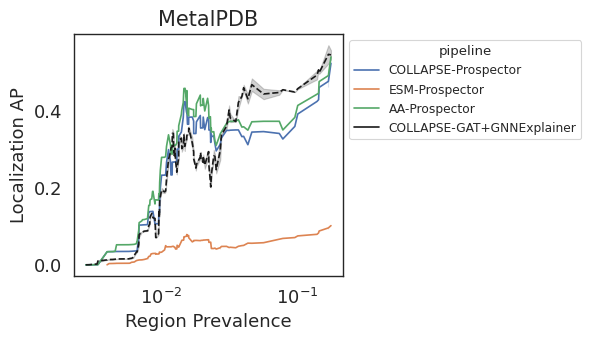

In [68]:
running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 30))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])

setup_figure(6,3.5)
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', hue_order=['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], palette=sns.color_palette()[:3] + ['k'])
g.lines[3].set_linestyle("--")

g.set_xscale("log")

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/k2-rp_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

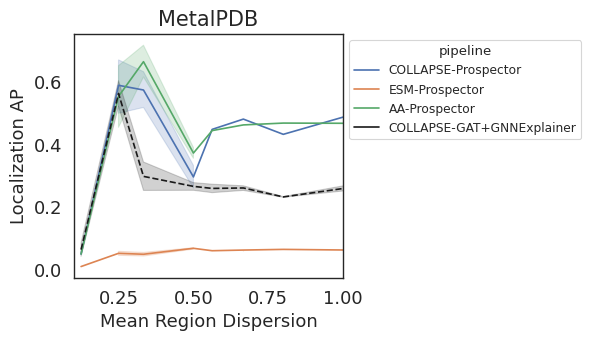

In [71]:
running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])


setup_figure(6,3.5)
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', hue_order=['COLLAPSE-Prospector', 'ESM-Prospector', 'AA-Prospector',
       'COLLAPSE-GAT+GNNExplainer'], palette=sns.color_palette()[:3] + ['k'])
g.lines[3].set_linestyle("--")

g.set_xlim(0.1, 1)
# g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/k2-mrd_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

# plotting test set results

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

# combined_df = pd.read_csv("/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv")

# test_df['method'] = ['Prospector']*len(test_df) #+ ['GAT+Explainer']*len(base_df)
combined_df = pd.concat([test_df, base_df])

In [20]:
combined_df.method.unique()

array(['Prospector', 'GAT+Attention', 'GAT+GNNExplainer', 'GAT+SHAP'],
      dtype=object)

/tmp/ipykernel_163045/1925769607.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_163045/1925769607.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_163045/1925769607.py:11: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='v

0.19882670373665381
0.06414380288632157
0.04316484601838743
0.3227948012162707
0.06044181009445501
0.35384010091516976
0.2663424367354532
0.04714701338091634
0.1211016987241592
0.16191639674043837
0.06213224232427596
0.062046489594188466
0
0
0
0


<Figure size 640x480 with 0 Axes>

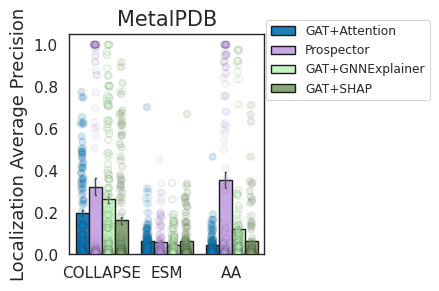

/tmp/ipykernel_163045/1925769607.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_163045/1925769607.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_163045/1925769607.py:11: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='v

0.17126351591919417
0.05017566568203427
0.03132584153565067
0.6403087354061556
0.08160103015985218
0.4054441225910138
0.24162602757794546
0.0362408723231687
0.10518790239247888
0.3704410263510019
0.30443074695422717
0.41969313432123584
0
0
0
0


<Figure size 640x480 with 0 Axes>

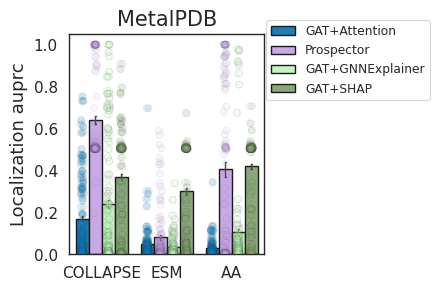

In [21]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["cerulean","lavender","celadon","sage","mahogany","goldenrod","violet","fuchsia"])
    if met in ['auprc', 'ap', 'auroc']:
        setup_figure(4.5,3)
        hue_order = ['GAT+Attention', 'Prospector', 'GAT+GNNExplainer', 'GAT+SHAP']
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("MetalPDB", fontsize=15)
        ax.set_ylabel(f'Localization {met.upper()}', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=11)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        plt.legend(loc=(1.01,0.7))
    elif met == 'precision':
        setup_figure(3,3)
        hue_order = ['GAT+Attention', 'Prospector', 'GAT+GNNExplainer', 'GAT+SHAP']
        ax = sns.barplot(data=subdf[subdf.regime == 'class-1'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'class-1'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("MetalPDB", fontsize=15)
        ax.set_ylabel('Precision', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=11)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        plt.legend(loc='upper left')
    # else:
    #     fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
    #     sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
    #     sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
    #     # ax1.yaxis.set_label_position('left')

    #     ax2.set_title('  '+'class-1', loc='left')
    #     ax2.set_ylabel('')
    #     ax2.set_yticklabels([])
    #     ax2.legend_.remove()
    
    #     sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
    #     sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
    #     ax1.legend_.remove()
    
    #     # optionally use the same scale left and right
    #     xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
    #     ax1.set_xlim(xmax=xmax)
    #     ax2.set_xlim(xmax=xmax)

    #     ax1.invert_xaxis()  # reverse the direction
    #     ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
    #     ax1.set_ylabel('')
    #     ax1.set_title('all data'+'  ', loc='right')

    #     plt.legend(loc=(-1.01,1.02))
    #     fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()

    plt.savefig("../data/figures/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.show()

In [27]:
combined_df.to_csv(f'../data/results/all_test_results_points_oldtest.csv')

In [ ]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].mean()

In [ ]:
combined_df[combined_df.regime == 'all'].groupby(['encoder','method'])['value'].sem()


In [ ]:
0.640309 - 0.376692